<a href="https://colab.research.google.com/github/wolfinwallst/Machine_Learning_Deep_basis/blob/main/RL_A3C_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[minimal RL github](https://github.com/seungeunrho/minimalRL/blob/master/a3c.py) 를 참고했다.

이해를 위해 주석을 많이 첨가했다.

`A3C` = 비동기 Actor-Critic 이다.

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# of episode :20, avg score : 29.4
# of episode :40, avg score : 26.2


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-1-4669d7c8430d>:95: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarra

# of episode :60, avg score : 25.6


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-1-4669d7c8430d>:95: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarra

# of episode :80, avg score : 18.2
# of episode :100, avg score : 12.8
# of episode :120, avg score : 13.8
# of episode :140, avg score : 16.9
# of episode :160, avg score : 16.4
# of episode :180, avg score : 17.6
# of episode :200, avg score : 19.8
# of episode :220, avg score : 14.7
Training process 2 reached maximum episode.
Training process 1 reached maximum episode.
# of episode :240, avg score : 22.9
Training process 3 reached maximum episode.
# of episode :260, avg score : 23.6
# of episode :280, avg score : 19.1
# of episode :300, avg score : 23.2
# of episode :320, avg score : 22.6
# of episode :340, avg score : 20.9
# of episode :360, avg score : 17.6
# of episode :380, avg score : 21.4


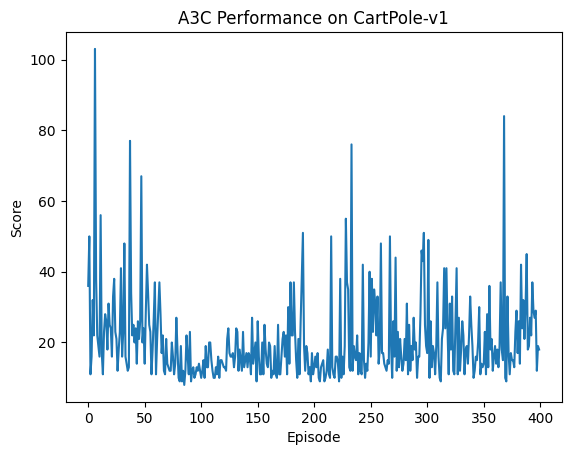

In [1]:
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.multiprocessing as mp

import matplotlib.pyplot as plt
import time

# 하이퍼파라미터 설정
n_train_processes = 3         # 학습에 사용할 프로세스 개수
learning_rate = 0.0002
update_interval = 5           # 로컬 업데이트 주기 (타임스텝 수)
gamma = 0.98
max_train_ep = 300            # 각 학습 프로세스에서 수행할 최대 에피소드 수
max_test_ep = 400             # 테스트 에피소드 수

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(4, 256) # CartPole의 상태는 4차원, hidden layer 크기는 256
        self.fc_pi = nn.Linear(256, 2) # policy 네트웤: CartPole의 행동은 2가지
        self.fc_v = nn.Linear(256, 1) # value 네트웤: 상태의 가치를 추정

    # actor 네트웤, 순서: input-fc1-relu-fc_pi-softmax
    def pi(self, x, softmax_dim=0):
        """
        정책망 forward 연산:
        - 입력 x를 fc1을 통해 hidden representation으로 변환 후 ReLU 적용
        - fc_pi를 통해 행동 점수를 얻고, softmax를 적용해 확률 분포로 변환
        """
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob
    # critic 네트웤, 순서: input-fc1-relu-fc_v
    def v(self, x):
        """
        가치망 forward 연산:
        - 입력 x를 fc1을 통해 hidden representation으로 변환 후 ReLU 적용
        - fc_v를 통해 상태의 가치를 추정
        """
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v

def train(global_model, rank):
    """
    각 학습 프로세스에서 동작하는 train 함수
    - 로컬 모델을 생성한 후, 전역 모델의 파라미터를 복사
    - 일정 간격(update_interval)마다 로컬에서 경험을 수집해 전역 모델 업데이트 수행
    """
    # 로컬 모델 생성 및 전역 모델 파라미터 복사
    """
    PyTorch에서 모델의 파라미터와 버퍼(예: 학습 중에 업데이트되는 running_mean,
    running_var 등)는 state_dict 라는 딕셔너리 형태로 관리된다.

    load_state_dict() 메서드는 주어진 state_dict를 모델의 파라미터에 로드한다.
    즉, 이 라인의 코드는 global_model에서 가져온 파라미터들을
    local_model에 복사하여, 두 모델의 파라미터가 동일한 상태가 되도록 동기화한다.
    """
    local_model = ActorCritic()
    local_model.load_state_dict(global_model.state_dict())

    optimizer = optim.Adam(global_model.parameters(), lr=learning_rate)
    env = gym.make('CartPole-v1')

    for n_epi in range(max_train_ep):
        done = False
        s = env.reset()

        while not done:
            s_lst, a_lst, r_lst = [], [], []
            # update_interval만큼 또는 에피소드 종료까지 경험을 저장
            for t in range(update_interval):
                # 정책에 따라 행동 선택
                prob = local_model.pi(torch.from_numpy(s).float())
                m = Categorical(prob)
                a = m.sample().item()
                s_prime, r, done, info = env.step(a)

                # 상태, 행동, 보상을 리스트에 저장 (보상은 정규화)
                s_lst.append(s)
                a_lst.append([a])
                r_lst.append(r/100.0)

                s = s_prime
                if done:
                    break
            """
            A3C에서 n-step return 을 계산하기 위해 추가된 코드
            """
            # 마지막 상태에 대한 가치 추정 (에피소드 종료시 0): Bootstrapping
            s_final = torch.tensor(s_prime, dtype=torch.float)
            R = 0.0 if done else local_model.v(s_final).item()
            td_target_lst = []
            # 역순으로 누적 보상(R)을 계산 (TD Target): n-step return
            for reward in r_lst[::-1]:
                R = gamma * R + reward
                td_target_lst.append([R])
            td_target_lst.reverse() # 원래 시간순서대로 되돌림

            """
            한 번에 여러 타임스텝의 경험(상태, 행동, 보상)을 모아 배치(batch) 형태로 처리하고,
            그 배치를 이용해 정책과 가치 네트워크의 업데이트를 위한 손실(loss)을 계산
            """
            s_batch = torch.tensor(s_lst, dtype=torch.float)
            a_batch = torch.tensor(a_lst)
            td_target = torch.tensor(td_target_lst)
            advantage = td_target - local_model.v(s_batch)

            # 정책 손실과 가치 손실 계산 후 더함
            pi = local_model.pi(s_batch, softmax_dim=1)
            pi_a = pi.gather(1, a_batch)
            loss = -torch.log(pi_a) * advantage.detach() + \
                   F.smooth_l1_loss(local_model.v(s_batch), td_target.detach())

            optimizer.zero_grad()
            loss.mean().backward() # local_model의 각 파라미터에 대해 손실(loss)을 미분한 그래디언트가 local_param.grad 에 저장됨
            # 로컬 모델의 그래디언트를 전역 모델에 복사
            for global_param, local_param in zip(global_model.parameters(), local_model.parameters()):
                global_param._grad = local_param.grad # 전역 모델이 업데이트되기 전에 전역 모델에 로컬에서 계산한 그래디언트를 수동으로 넣어주는 과정
            optimizer.step() # 전역 모델의 파라미터에 저장된 _grad 를 사용해 파라미터 업데이트
            # 업데이트된 전역 모델의 파라미터를 다시 로컬 모델에 반영(복사)
            local_model.load_state_dict(global_model.state_dict())

    env.close()
    print("Training process {} reached maximum episode.".format(rank))

def test(global_model):
    """
    테스트 프로세스에서 동작하는 함수
    - 전역 모델을 이용해 테스트 에피소드를 실행하고 각 에피소드의 점수를 기록
    - 일정 간격(print_interval)마다 평균 점수를 출력하며, 학습 종료 후 전체 성능을 plot으로 시각화
    """
    env = gym.make('CartPole-v1')
    print_interval = 20  # 출력 간격
    all_scores = []      # 각 에피소드의 점수(누적 보상)를 저장할 리스트

    for n_epi in range(max_test_ep):
        done = False
        s = env.reset()
        score = 0.0  # 에피소드마다 점수 초기화
        while not done:
            # 전역 모델의 정책에 따라 행동 선택
            prob = global_model.pi(torch.from_numpy(s).float())
            a = Categorical(prob).sample().item()
            s_prime, r, done, info = env.step(a)
            s = s_prime
            score += r  # 에피소드의 보상 누적
        all_scores.append(score)
        # 일정 에피소드마다 최근 print_interval 에피소드의 평균 점수를 출력
        if n_epi % print_interval == 0 and n_epi != 0:
            avg_score = sum(all_scores[-print_interval:]) / print_interval
            print("# of episode :{}, avg score : {:.1f}".format(n_epi, avg_score))
            time.sleep(1)
    env.close()

    plt.figure()
    plt.plot(all_scores)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('A3C Performance on CartPole-v1')
    plt.savefig("performance_plot.png")  # 성능 그래프를 파일로 저장
    plt.show()

# 여기부턴 main() 함수나 마찬가지
# 전역 모델 생성 후, 멀티프로세싱을 위해 메모리 공유 설정
global_model = ActorCritic()
global_model.share_memory()

processes = []
"""
n_train_processes = 3 이므로 rank == 0이면 test() 함수 실행
rank == 1, 2, 3 에서는 train() 함수가 실행된다.

따라서 전체적으로 4개의 프로세스가 실행되며, 학습을 수행하는 worker는 3개

p.start()를 통해 각 프로세스가 동시에 실행됨
모든 프로세스는 메인 프로세스와 별도로 독립적으로 동작하며, 특히 global_model은
share_memory()를 통해 메모리를 공유하여 각 프로세스가 동일한 모델 파라미터에 접근하고
업데이트할 수 있다

p.join()을 통해 메인 프로세스는 모든 프로세스가 종료될 때까지 대기

"""
# 학습 프로세스와 테스트 프로세스 생성 (+1은 테스트 프로세스)
for rank in range(n_train_processes + 1):
    if rank == 0:
        # rank가 0이면 테스트 프로세스로 test() 함수를 실행
        p = mp.Process(target=test, args=(global_model,))
    else:
        # 나머지 프로세스는 학습을 위한 train() 함수를 실행
        p = mp.Process(target=train, args=(global_model, rank,))

    # 생성된 프로세스를 동시에 시작(병렬 실행): 호출시 별도의 새로운 프로세스가 생성되고, 지정된 target 함수(test() 또는 train())가 실행된다.
    p.start()
    processes.append(p)
for p in processes:
    p.join() # 모든 worker(즉 train)와 테스트 프로세스가 종료될 때까지 메인 스크립트의 종료를 지연시킨다.

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# of episode :20, avg score : 18.4
# of episode :40, avg score : 19.0


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-4-cdba2f6fd511>:96: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarra

# of episode :60, avg score : 18.9


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-4-cdba2f6fd511>:96: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarra

# of episode :80, avg score : 9.7
# of episode :100, avg score : 9.3
# of episode :120, avg score : 10.8
# of episode :140, avg score : 10.9
Training process 2 reached maximum episode.
Training process 3 reached maximum episode.
Training process 1 reached maximum episode.
# of episode :160, avg score : 13.3
# of episode :180, avg score : 13.1
# of episode :200, avg score : 12.7
# of episode :220, avg score : 13.3
# of episode :240, avg score : 14.2
# of episode :260, avg score : 12.9
# of episode :280, avg score : 13.2
# of episode :300, avg score : 13.4
# of episode :320, avg score : 15.7
# of episode :340, avg score : 12.3
# of episode :360, avg score : 14.8
# of episode :380, avg score : 12.6


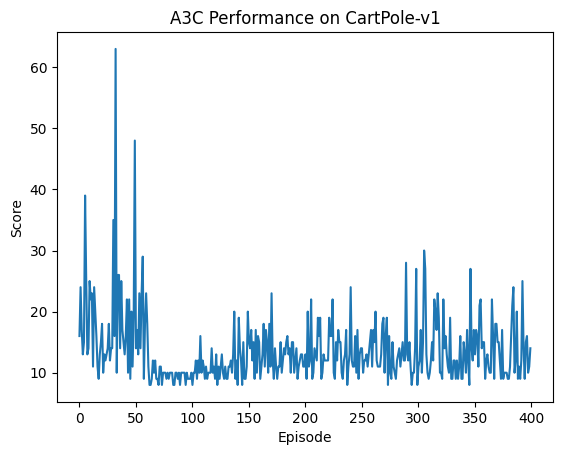

In [4]:
# 지워도 된다: 어차피 위에거 복붙
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.multiprocessing as mp
import matplotlib.pyplot as plt  # 성능 시각화를 위한 라이브러리
import time

# 하이퍼파라미터 설정
n_train_processes = 3         # 학습에 사용할 프로세스 개수
learning_rate = 0.0002        # 학습률
update_interval = 5           # 로컬 업데이트 주기 (타임스텝 수)
gamma = 0.98                  # 할인 계수
max_train_ep = 300            # 각 학습 프로세스에서 수행할 최대 에피소드 수
max_test_ep = 400             # 테스트 에피소드 수

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        # CartPole의 상태는 4차원, hidden layer 크기는 256
        self.fc1 = nn.Linear(4, 256)
        # 정책망: CartPole의 행동은 2가지
        self.fc_pi = nn.Linear(256, 2)
        # 가치망: 상태의 가치를 추정
        self.fc_v = nn.Linear(256, 1)

    def pi(self, x, softmax_dim=0):
        """
        정책망 forward 연산:
        - 입력 x를 fc1을 통해 hidden representation으로 변환 후 ReLU 적용
        - fc_pi를 통해 행동 점수를 얻고, softmax를 적용해 확률 분포로 변환
        """
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob

    def v(self, x):
        """
        가치망 forward 연산:
        - 입력 x를 fc1을 통해 hidden representation으로 변환 후 ReLU 적용
        - fc_v를 통해 상태의 가치를 추정
        """
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v

def train(global_model, rank):
    """
    각 학습 프로세스에서 동작하는 train 함수
    - 로컬 모델을 생성한 후, 전역 모델의 파라미터를 복사
    - 일정 간격(update_interval)마다 로컬에서 경험을 수집해 전역 모델 업데이트 수행
    """
    # 로컬 모델 생성 및 전역 모델 파라미터 복사
    local_model = ActorCritic()
    local_model.load_state_dict(global_model.state_dict())

    optimizer = optim.Adam(global_model.parameters(), lr=learning_rate)
    env = gym.make('CartPole-v1')

    for n_epi in range(max_train_ep):
        done = False
        s = env.reset()
        while not done:
            s_lst, a_lst, r_lst = [], [], []
            # update_interval만큼 또는 에피소드 종료까지 경험을 저장
            for t in range(update_interval):
                # 정책에 따라 행동 선택
                prob = local_model.pi(torch.from_numpy(s).float())
                m = Categorical(prob)
                a = m.sample().item()
                s_prime, r, done, info = env.step(a)

                # 상태, 행동, 보상을 리스트에 저장 (보상은 정규화)
                s_lst.append(s)
                a_lst.append([a])
                r_lst.append(r/100.0)

                s = s_prime
                if done:
                    break

            # 마지막 상태에 대한 가치 추정 (에피소드 종료시 0)
            s_final = torch.tensor(s_prime, dtype=torch.float)
            R = 0.0 if done else local_model.v(s_final).item()
            td_target_lst = []
            # 역순으로 누적 보상(R)을 계산 (TD Target)
            for reward in r_lst[::-1]:
                R = gamma * R + reward
                td_target_lst.append([R])
            td_target_lst.reverse()

            s_batch = torch.tensor(s_lst, dtype=torch.float)
            a_batch = torch.tensor(a_lst)
            td_target = torch.tensor(td_target_lst)
            advantage = td_target - local_model.v(s_batch)

            # 정책 손실과 가치 손실 계산
            pi = local_model.pi(s_batch, softmax_dim=1)
            pi_a = pi.gather(1, a_batch)
            loss = -torch.log(pi_a) * advantage.detach() + \
                   F.smooth_l1_loss(local_model.v(s_batch), td_target.detach())

            optimizer.zero_grad()
            loss.mean().backward()
            # 로컬 모델의 그래디언트를 전역 모델에 복사
            for global_param, local_param in zip(global_model.parameters(), local_model.parameters()):
                global_param._grad = local_param.grad
            optimizer.step()
            # 업데이트된 전역 모델의 파라미터를 로컬 모델에 반영
            local_model.load_state_dict(global_model.state_dict())

    env.close()
    print("Training process {} reached maximum episode.".format(rank))

def test(global_model):
    """
    테스트 프로세스에서 동작하는 함수
    - 전역 모델을 이용해 테스트 에피소드를 실행하고 각 에피소드의 점수를 기록
    - 일정 간격(print_interval)마다 평균 점수를 출력하며, 학습 종료 후 전체 성능을 plot으로 시각화
    """
    env = gym.make('CartPole-v1')
    print_interval = 20  # 출력 간격
    all_scores = []      # 각 에피소드의 점수를 저장할 리스트

    for n_epi in range(max_test_ep):
        done = False
        s = env.reset()
        score = 0.0  # 에피소드마다 점수 초기화
        while not done:
            # 전역 모델의 정책에 따라 행동 선택
            prob = global_model.pi(torch.from_numpy(s).float())
            a = Categorical(prob).sample().item()
            s_prime, r, done, info = env.step(a)
            s = s_prime
            score += r  # 에피소드의 보상 누적
        all_scores.append(score)
        # 일정 에피소드마다 최근 print_interval 에피소드의 평균 점수를 출력
        if n_epi % print_interval == 0 and n_epi != 0:
            avg_score = sum(all_scores[-print_interval:]) / print_interval
            print("# of episode :{}, avg score : {:.1f}".format(n_epi, avg_score))
            time.sleep(1)
    env.close()

    # 테스트 결과를 plot으로 시각화
    plt.figure()
    plt.plot(all_scores)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('A3C Performance on CartPole-v1')
    plt.savefig("performance_plot.png")  # 성능 그래프를 파일로 저장
    plt.show()

# 전역 모델 생성 후, 멀티프로세싱을 위해 메모리 공유 설정
global_model = ActorCritic()
global_model.share_memory()

processes = []
# 학습 프로세스와 테스트 프로세스 생성 (+1은 테스트 프로세스)
for rank in range(n_train_processes + 1):
    if rank == 0:
        p = mp.Process(target=test, args=(global_model,))
    else:
        p = mp.Process(target=train, args=(global_model, rank,))
    p.start()
    processes.append(p)
for p in processes:
    p.join()

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# of episode :20, avg score : 24.8
# of episode :40, avg score : 20.1


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-4-cdba2f6fd511>:96: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarra

# of episode :60, avg score : 11.2


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is 

# of episode :80, avg score : 34.2
# of episode :100, avg score : 65.0
# of episode :120, avg score : 20.9
# of episode :140, avg score : 9.3
# of episode :160, avg score : 9.4
# of episode :180, avg score : 9.6
Training process 1 reached maximum episode.
# of episode :200, avg score : 9.4
Training process 5 reached maximum episode.
Training process 2 reached maximum episode.
Training process 4 reached maximum episode.
Training process 3 reached maximum episode.
# of episode :220, avg score : 9.7
# of episode :240, avg score : 9.7
# of episode :260, avg score : 9.5
# of episode :280, avg score : 9.2
# of episode :300, avg score : 9.2
# of episode :320, avg score : 9.2
# of episode :340, avg score : 9.2
# of episode :360, avg score : 9.6
# of episode :380, avg score : 9.3


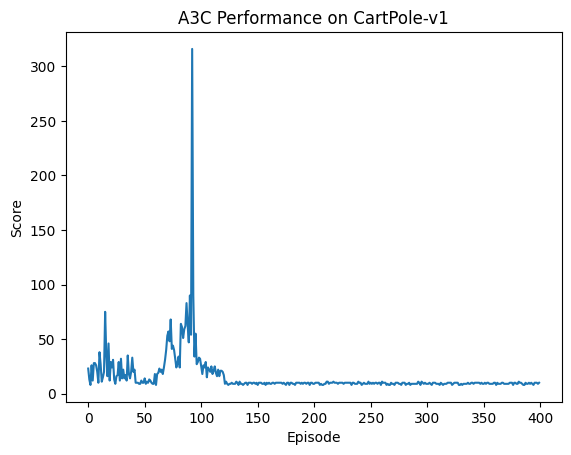

In [6]:
# 하이퍼 파라미터 튜닝 후, (세 번째) 시도

# 하이퍼파라미터 설정
n_train_processes = 5         # 학습에 사용할 프로세스 개수
learning_rate = 0.01          # 학습률
update_interval = 5           # 로컬 업데이트 주기 (타임스텝 수)
gamma = 0.98                  # 할인 계수
max_train_ep = 300            # 각 학습 프로세스에서 수행할 최대 에피소드 수
max_test_ep = 400             # 테스트 에피소드 수

global_model = ActorCritic()
global_model.share_memory()

processes = []
# 학습 프로세스와 테스트 프로세스 생성 (+1은 테스트 프로세스)
for rank in range(n_train_processes + 1):
    if rank == 0:
        p = mp.Process(target=test, args=(global_model,))
    else:
        p = mp.Process(target=train, args=(global_model, rank,))
    p.start()
    processes.append(p)
for p in processes:
    p.join()